# Sentiment based content-based recommendation system

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

train_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/dataset_with_sentiment_score/RecSys_AspectSentiment_train.csv")
test_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/dataset_with_sentiment_score/RecSys_AspectSentiment_test.csv")
beers_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/cleaned_beers.csv")
sentiment_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/dataset_with_sentiment_score/prediction_sentiment_score.csv") 

train_df

,username,beer_id,feel_predicted_rating,look_predicted_rating,smell_predicted_rating,taste_predicted_rating,feel_true_rating,look_true_rating,smell_true_rating,taste_true_rating,date,text,overall,score
0,Mitchster,2614,3.960000,3.940000,3.940000,3.940000,2.500000,3.500000,3.500000,3.500000,2005-02-18,recommended nick liquormax loveland. bottle co...,3.00,3.30
1,avalon07,13874,4.270000,4.255000,4.260000,4.255000,3.750000,4.125000,3.625000,3.625000,2018-04-14,l: poured bottle pint glass. amber color cloud...,3.75,3.81
2,Kulrak,3999,2.420000,2.410000,2.420000,2.420000,2.000000,3.000000,1.500000,1.500000,2007-05-28,pours somewhat dark golden color crumbly white...,2.00,1.74
3,jampics2,95343,3.475000,3.425000,3.425000,3.450000,3.125000,3.750000,3.125000,2.750000,2013-07-01,"happy 25th great lakes! so, going hoppy lager ...",2.50,2.48
4,lacqueredmouse,28314,1.870000,1.870000,1.890000,1.900000,1.000000,2.000000,2.000000,1.000000,2006-11-04,"clear light yellow body, coarse-bubbled scummy...",1.50,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15518,callmemickey,57269,2.912500,2.895000,2.895000,2.895000,3.125000,3.500000,3.500000,2.500000,2010-06-03,a: pale golden-yellow body. fluffy white head....,3.50,3.18
15519,cvstrickland,6549,3.700000,3.668333,3.675000,3.693333,3.833333,4.500000,4.000000,3.666667,2008-11-11,24-ounce fatty bomber bottle poured new duck-r...,4.50,4.25
15520,MJR,1520,3.250000,3.235000,3.230000,3.230000,3.000000,3.250000,3.500000,3.500000,2003-01-19,"appearance: scale black brown, one shade brown...",2.50,2.88
15521,BeerBelcher,34688,2.779474,2.763684,2.777368,2.783684,2.763158,3.052632,2.605263,2.342105,2007-06-11,"unless purpose beer disappoint me, believe suc...",2.00,2.19


In [2]:
beers_df

,id,style,availability,country,abv
0,267989,American IPA,Rotating,CA,5.900000
1,343558,American IPA,Rotating,US,6.500000
2,302786,American IPA,Rotating,US,5.600000
3,153878,American IPA,Limited (brewed once),US,7.600000
4,75066,American IPA,Fall,US,7.200000
...,...,...,...,...,...
92415,367916,Wild/Sour Beers,Limited (brewed once),US,5.500000
92416,367956,Wild/Sour Beers,Rotating,US,6.000000
92417,367929,Wild/Sour Beers,Limited (brewed once),US,5.200000
92418,367924,Wild/Sour Beers,Rotating,US,5.700000


# Feature Engineering

In [3]:
# Merge train and beers data
train_merged = train_df.merge(beers_df, left_on='beer_id', right_on='id', how='left')
test_merged = test_df.merge(beers_df, left_on='beer_id', right_on='id', how='left')
beers_df = beers_df.merge(sentiment_df, left_on='id', right_on='beer_id', how='left')

In [4]:
# Select columns used for feature engineering
categorical_cols = ['style', 'availability', 'country']
numerical_cols = ['abv', 'look_predicted_rating', 'smell_predicted_rating', 
                  'taste_predicted_rating', 'feel_predicted_rating']

# Remove samples with missing values
train_merged = train_merged.dropna(subset=categorical_cols + numerical_cols)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = encoder.fit_transform(train_merged[categorical_cols])

# Min-Max normalize numerical features
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(train_merged[numerical_cols])
abv_part = numerical_features[:, [0]]
sentiment_part = numerical_features[:, 1:] * 0.3
numerical_features = np.hstack((abv_part, sentiment_part))

# Hybrid Feature Construction

In [5]:
# Build complete beer feature matrix
beer_features = np.hstack((categorical_features, numerical_features))
beer_ids = train_merged['beer_id'].values
beer_feature_df = pd.DataFrame(beer_features, index=beer_ids)

# Aggregate each beer’s features (deduplicate)
beer_feature_df = beer_feature_df.groupby(beer_feature_df.index).mean()

# Build user profiles (weighted average of beer features the user has rated)
user_profiles = {}
for user, group in train_merged.groupby('username'):
    rated_beers = group['beer_id']
    ratings = group['taste_true_rating'].values
    features = beer_feature_df.loc[rated_beers]
    user_vector = np.average(features, axis=0, weights=ratings)
    user_profiles[user] = user_vector

In [6]:

# Build TF-IDF Vectors (Text Review Features
from sklearn.feature_extraction.text import TfidfVectorizer

# Load Review Data
reviews_df = pd.read_csv('D:/Master/FSS_25/Web_Mining/Project/data/reviews_stratified_sampled.csv')
reviews_df = reviews_df.dropna(subset=['text'])
reviews_df['beer_id'] = reviews_df['beer_id'].astype(int)

# Combine All Reviews per Beer
beer_texts = reviews_df.groupby('beer_id')['text'].apply(lambda x: ' '.join(x)).reset_index()

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=300)
tfidf_matrix = tfidf.fit_transform(beer_texts['text'])
beer_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=beer_texts['beer_id'])


# Hybrid Content-Based Recommendation

In [7]:

# Combine Structured Features + TF-IDF Features
common_beers = beer_feature_df.index.intersection(beer_tfidf_df.index)

beer_combined_features = np.hstack((
    beer_feature_df.loc[common_beers].values,
    beer_tfidf_df.loc[common_beers].values
))


In [8]:

# Build User Profiles (Based on Combined Features)
user_profiles = {}
train_common = train_merged[train_merged['beer_id'].isin(common_beers)]

for user, group in train_common.groupby('username'):
    beer_ids = group['beer_id']
    ratings = group['taste_true_rating'].values
    indices = [list(common_beers).index(b) for b in beer_ids if b in common_beers]
    if indices:
        features = beer_combined_features[indices]
        user_vector = np.average(features, axis=0, weights=ratings[:len(features)])
        user_profiles[user] = user_vector


In [9]:

# Generate Top-N Recommendations Based on Combined Features
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

recommendations = {}

for user, profile in user_profiles.items():
    sim_scores = cosine_similarity(profile.reshape(1, -1), beer_combined_features).flatten()
    sim_series = pd.Series(sim_scores, index=common_beers)
    rated_beers = train_common[train_common['username'] == user]['beer_id']
    sim_series = sim_series.drop(index=rated_beers, errors='ignore')
    top_beers = sim_series.sort_values(ascending=False).head(10).index.tolist()
    recommendations[user] = top_beers


# Hybrid Feature-Based Top-N Recommendation

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Load review data
reviews_df = pd.read_csv('D:/Master/FSS_25/Web_Mining/Project/data/reviews_stratified_sampled.csv')
reviews_df = reviews_df.dropna(subset=['text'])
reviews_df['beer_id'] = reviews_df['beer_id'].astype(int)

# Merge all reviews for each beer
beer_texts = reviews_df.groupby('beer_id')['text'].apply(lambda x: ' '.join(x)).reset_index()

# Generate TF-IDF vectors
tfidf = TfidfVectorizer(max_features=300)
tfidf_matrix = tfidf.fit_transform(beer_texts['text'])

# Convert to DataFrame and align index
beer_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=beer_texts['beer_id'])

# Align beer_struct_df from previous step with TF-IDF
common_beers = beer_feature_df.index.intersection(beer_tfidf_df.index)
beer_combined_features = np.hstack((
    beer_feature_df.loc[common_beers].values,
    beer_tfidf_df.loc[common_beers].values
))

# Build new user profiles using hybrid features
user_profiles = {}
train_common = train_merged[train_merged['beer_id'].isin(common_beers)]
for user, group in train_common.groupby('username'):
    beer_ids = group['beer_id']
    ratings = group['taste_true_rating'].values
    indices = [list(common_beers).index(b) for b in beer_ids if b in common_beers]
    if indices:
        features = beer_combined_features[indices]
        user_vector = np.average(features, axis=0, weights=ratings[:len(features)])
        user_profiles[user] = user_vector

# Generate recommendations using hybrid feature vectors
recommendations = {}
for user, profile in user_profiles.items():
    sim_scores = cosine_similarity(profile.reshape(1, -1), beer_combined_features).flatten()
    sim_series = pd.Series(sim_scores, index=common_beers)
    rated_beers = train_common[train_common['username'] == user]['beer_id']
    sim_series = sim_series.drop(index=rated_beers, errors='ignore')
    top_beers = sim_series.sort_values(ascending=False).head(10).index.tolist()
    recommendations[user] = top_beers

# Top-N & Rating Prediction

In [11]:
# Recommend unrated beers for each user (based on cosine similarity)
recommendations = {}
for user, profile_vector in user_profiles.items():
    profile_vector = profile_vector.reshape(1, -1)
    sim_scores = cosine_similarity(profile_vector, beer_combined_features).flatten()
    sim_series = pd.Series(sim_scores, index=common_beers)

    rated = train_merged[train_merged['username'] == user]['beer_id'].tolist()
    sim_series = sim_series.drop(index=rated, errors='ignore')

    top_beers = sim_series.sort_values(ascending=False).head(10).index.tolist()
    recommendations[user] = top_beers

# Convert to DataFrame for easy viewing or saving
recommendation_df = pd.DataFrame([
    {'username': user, 'recommended_beers': beers}
    for user, beers in recommendations.items()
])

# Output result
recommendation_df.head()

,username,recommended_beers
0,108Dragons,"[36170, 7941, 1307, 35625, 808, 1934, 99, 727,..."
1,1099,"[1320, 1524, 332, 1390, 3734, 20732, 43043, 27..."
2,1234Jack,"[65, 2280, 1276, 1642, 653, 1299, 580, 2947, 3..."
3,1sophrosyne1,"[16471, 31255, 51557, 75414, 12690, 36333, 540..."
4,20ozmonkey,"[411, 59781, 7096, 695, 3457, 1385, 43905, 694..."


In [12]:
predictions = []

for user, profile_vector in user_profiles.items():
    profile_vector = profile_vector.reshape(1, -1)
    sim_scores = cosine_similarity(profile_vector, beer_combined_features).flatten()
    sim_scores_scaled = sim_scores * 5.0  
    for beer_id, score in zip(common_beers, sim_scores_scaled):
        predictions.append((user, beer_id, score))

pred_df = pd.DataFrame(predictions, columns=['username', 'beer_id', 'predicted_rating'])


# Evaluation

MSE: 2.110
RMSE: 1.452
MAE: 1.187


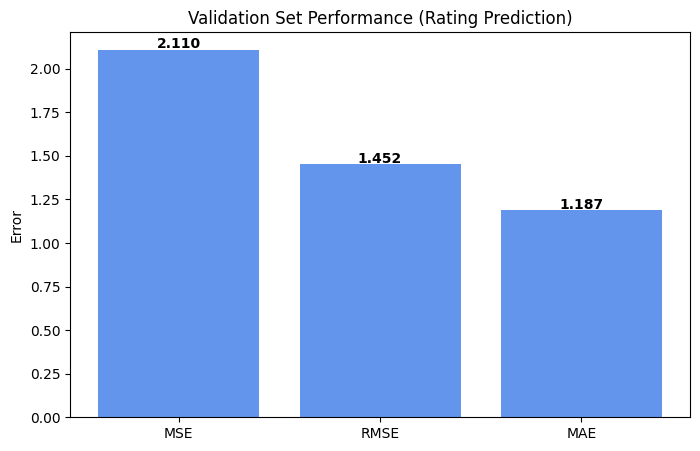

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load test set with true ratings
test_df_subset = test_df[['username', 'beer_id', 'taste_true_rating']]
eval_df = pd.merge(test_df_subset, pred_df, on=['username', 'beer_id'])

# Calculate prediction errors
mse = mean_squared_error(eval_df['taste_true_rating'], eval_df['predicted_rating'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(eval_df['taste_true_rating'], eval_df['predicted_rating'])

print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Visualize error metrics
metrics = [mse, rmse, mae]
names = ['MSE', 'RMSE', 'MAE']

plt.figure(figsize=(8, 5))
plt.bar(names, metrics, color='cornflowerblue')
for i, val in enumerate(metrics):
    plt.text(i, val + 0.01, f"{val:.3f}", ha='center', fontweight='bold')
plt.ylabel("Error")
plt.title("Validation Set Performance (Rating Prediction)")
plt.ylim(0, max(metrics) + 0.1)
plt.show()

In [15]:
# Top-N recommendation evaluation metrics (Precision@10, NDCG@10)
# Recommend top 10 beers for each user
recommendations = {}
for user, profile_vector in user_profiles.items():
    profile_vector = profile_vector.reshape(1, -1)
    sim_scores = cosine_similarity(profile_vector, beer_combined_features).flatten()
    sim_series = pd.Series(sim_scores, index=common_beers)

    rated_beers = train_df[train_df['username'] == user]['beer_id'].tolist()
    sim_series = sim_series.drop(index=rated_beers, errors='ignore')

    top_beers = sim_series.sort_values(ascending=False).head(10).index.tolist()
    recommendations[user] = top_beers

# Ground truth from test set
ground_truth = test_df.groupby('username')['beer_id'].apply(set).to_dict()

# Precision@10
def precision_at_k(recommendations, ground_truth, k=10):
    precisions = []
    for user, rec_beers in recommendations.items():
        if user not in ground_truth:
            continue
        true_beers = ground_truth[user]
        hit_count = len(set(rec_beers[:k]) & true_beers)
        precisions.append(hit_count / k)
    return np.mean(precisions)

# NDCG@10
def ndcg_at_k(recommendations, ground_truth, k=10):
    def dcg(rels):
        return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))
    scores = []
    for user, rec_beers in recommendations.items():
        if user not in ground_truth:
            continue
        true_beers = ground_truth[user]
        relevance = [1 if beer in true_beers else 0 for beer in rec_beers[:k]]
        ideal_relevance = sorted(relevance, reverse=True)
        ndcg = dcg(relevance) / dcg(ideal_relevance) if sum(ideal_relevance) > 0 else 0.0
        scores.append(ndcg)
    return np.mean(scores)

# Hit@10
def hit_rate_at_k(recommendations, ground_truth, k=10):
    hits = 0
    total = 0
    for user, rec_beers in recommendations.items():
        if user not in ground_truth:
            continue
        true_beers = ground_truth[user]
        if len(set(rec_beers[:k]) & true_beers) > 0:
            hits += 1
        total += 1
    return hits / total if total > 0 else 0.0

# Output Top-N recommendation evaluation results
precision = precision_at_k(recommendations, ground_truth, k=10)
ndcg = ndcg_at_k(recommendations, ground_truth, k=10)
hit_rate = hit_rate_at_k(recommendations, ground_truth, k=10)

print(f"\nTop-N Evaluation:")
print(f"Precision@10: {precision:.4f}")
print(f"NDCG@10: {ndcg:.4f}")
print(f"Hit@10: {hit_rate:.4f}")


Top-N Evaluation:
Precision@10: 0.0025
NDCG@10: 0.0117
Hit@10: 0.0250


# Comparison Summary: Content-Based Model With vs Without Sentiment Score

The content-based hybrid model with sentiment score shows a clear improvement over the version without sentiment:

- **RMSE** decreased from 2.484 to 1.452

- **MAE** decreased from 2.185 to 1.187

- **MSE** decreased from 6.169 to 2.110

These results demonstrate that incorporating aspect-level sentiment information (e.g., from beer reviews) significantly improves the model’s ability to predict user preferences and generate more accurate recommendations.

Top-N Recommendation Accuracy:
- **Precision@10** increased from 0.0003 to 0.0025

- **NDCG@10** increased from 0.0009 to 0.0117

- **Hit@10** increased from 0.0023 to 0.00250

These results show that incorporating sentiment information improves the ranking quality of recommendations—especially in terms of NDCG, which emphasizes top-ranked relevance.